# Let's Explore Airbnb rental landscape in Seattle city 


1. How do prices of listings vary by location/neighbourhood?
2. How do the ratings vary by location/neighbourhood?
3. What are the different types of properties in Seattle? 
4. How is the popularity for Airbnb in Seattle? [*added a new question*]
5. How does the demand for Airbnb rentals fluctuate across the year?
6. Is there a correlation between demand and prices of the rentals? [*Not sufficient data to answer it but tried*]
7. What is the occupancy rate for next year?
8. Is it expensive to travel on weekends? [*added a new question*]
9. What is the opinion of the guests about Seattle Airbnbs? [*added a new question*]
10. What makes a host a Super host?

*Will not be able to cover these last questions due to limitations of time.*

11. Do cancellation and booking policies between a host and a super host differ?
12. What aspects of the rental experience do people like and what aspects do they detest? [*this requires ML but will try to answer something from wordcloud in #8*]

In [ ]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express
# Install Wordcloud
!pip install wordcloud


# Install plotnine for ggplot2
# !pip install plotnine

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,424 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../python3-numpy_

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
from shapely.geometry import Point , polygon
from wordcloud import WordCloud, STOPWORDS

# from plotnine import *
# from plotnine.data import *

import seaborn as sns

# Add csv files to the data frame

In [ ]:
listings = pd.read_csv('/content/drive/MyDrive/Airbnb/listings.csv')
reviews = pd.read_csv('/content/drive/MyDrive/Airbnb/reviews.csv')
calendar = pd.read_csv('/content/drive/MyDrive/Airbnb/calendar.csv')
neighbourhoods = pd.read_csv('/content/drive/MyDrive/Airbnb/neighbourhoods.csv')

In [ ]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2318,https://www.airbnb.com/rooms/2318,20211023135601,2021-10-23,Casa Madrona - Urban Oasis 1 block from the park!,"Gorgeous, architect remodeled, Dutch Colonial ...",Madrona is a hidden gem of a neighborhood. It ...,https://a0.muscache.com/pictures/02973ad3-a7a3...,2536,https://www.airbnb.com/users/show/2536,Megan,2008-08-26,"Seattle, Washington, United States",I welcome guests from all walks of life and ev...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/016a1...,https://a0.muscache.com/im/pictures/user/016a1...,Minor,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Seattle, Washington, United States",Madrona,Central Area,47.61082,-122.29082,Entire residential home,Entire home/apt,9,NaN,2.5 baths,4.0,4.0,"[""Smoke alarm"", ""First aid kit"", ""Wifi"", ""Refr...",$296.00,7,1125,7.0,7.0,1125.0,1125.0,7.0,1125.0,NaN,t,0,5,28,208,2021-10-23,35,3,0,2017-01-10,2021-08-07,4.97,5.00,5.00,5.00,5.00,4.97,4.82,STR-OPLI-19-002837,t,1,1,0,0,0.60
1,6606,https://www.airbnb.com/rooms/6606,20211023135601,2021-10-23,"Fab, private seattle urban cottage!","This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...",https://a0.muscache.com/pictures/45742/21116d7...,14942,https://www.airbnb.com/users/show/14942,Joyce,2009-04-26,"Seattle, Washington, United States",I am a therapist/innkeeper.I know my city well...,within a few hours,90%,92%,f,https://a0.muscache.com/im/users/14942/profile...,https://a0.muscache.com/im/users/14942/profile...,Wallingford,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65411,-122.33761,Entire guesthouse,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Smoke alarm"", ""Wifi"", ""Shampoo"", ""Essentials...",$99.00,3,1125,3.0,3.0,1125.0,1125.0,3.0,1125.0,NaN,t,0,0,0,0,2021-10-23,157,8,0,2016-05-30,2021-09-14,4.60,4.67,4.67,4.82,4.76,4.88,4.56,str-opli-19-002622,f,2,2,0,0,2.39
2,9419,https://www.airbnb.com/rooms/9419,20211023135601,2021-10-23,Glorious sun room w/ memory foambed,"Keeping you safe is our priority, we are adher...","Lots of restaurants (see our guide book) bars,...",https://a0.muscache.com/pictures/56645186/e5fb...,30559,https://www.airbnb.com/users/show/30559,Angielena,2009-08-09,"Seattle, Washington, United States",I am a visual artist who is the director of ...,within a few hours,100%,88%,t,https://a0.muscache.com/im/users/30559/profile...,https://a0.muscache.com/im/users/30559/profile...,Georgetown,9.0,9.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Seattle, Washington, United States",Georgetown,Other neighborhoods,47.55017,-122.31937,Priv


*   **The listings dataset has 74 attributes**
*   **There are total 4351 listings in the Seattle area**


 

# Data Cleaning and Exploration

In [ ]:
# Converting object to datetime format

listings['host_since'] = pd.to_datetime(listings['host_since']).dt.date

In [ ]:
listings.loc[(listings['host_since'] == min(listings['host_since'])), ['host_name', 'host_since','host_location', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type']]

,host_name,host_since,host_location,host_neighbourhood,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type
0,Megan,2008-08-26,"Seattle, Washington, United States",Minor,"Seattle, Washington, United States",Madrona,Central Area,Entire residential home


**According to the data, the first listing in Seattle was of a residential home hosted on 2008-08-26 by Megan in the Madrona neighbourhood.**

In [ ]:
# Removing the $ sign from the price
listings['price'] = listings['price'].replace({'\$':''}, regex = True)

# setting precision to 2
pd.set_option('display.float_format','{:.2f}'.format)

# convert price object to float
listings['price'] = pd.to_numeric(listings['price'],errors = 'coerce')

# Remove listings with price of $0
listings = listings[listings['price'] != 0.00]

# Check statics summary for the price
print(listings['price'].describe())

count   4330.00
mean     151.83
std      104.67
min       13.00
25%       87.00
50%      125.00
75%      182.00
max      999.00
Name: price, dtype: float64


**The price of the listings in Seattle range from $\$$ 13 to $\$$ 999**

In [ ]:
listings.loc[listings['price'] == 999.00, ['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type']]

,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type
144,"Seattle, Washington, United States",Broadview,Other neighborhoods,Private room in townhouse
145,"Seattle, Washington, United States",Broadview,Other neighborhoods,Private room in townhouse


**The listing with price of $\$$ 999 is a Private room in townhouse in Broadview neighbourhood of Seattle.**

In [ ]:
# Series vector for a prices with of the listing with min 1 night stay
price_of_min_1_night_listings = listings.loc[listings['minimum_nights'] == 1, 'price']

print("\nThe Min price of the property listed with minimum 1 night stay : ", min(price_of_min_1_night_listings))
print("The Max price of the property listed with minimum 1 night stay : ", max(price_of_min_1_night_listings))


The Min price of the property listed with minimum 1 night stay :  19.0
The Max price of the property listed with minimum 1 night stay :  799.0


**The price of the listings with minimum 1 night stay with in Seattle range from $\$$ 19 to $\$$ 799**

In [ ]:
# Getting rid of limitations of displaying result
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
# check for count of null values in each column
listings.isna().sum()

id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
name                                               0
description                                        7
neighborhood_overview                           1134
picture_url                                        0
host_id                                            0
host_url                                           0
host_name                                          1
host_since                                         1
host_location                                      6
host_about                                      1154
host_response_time                               805
host_response_rate                               805
host_acceptance_rate                             732
host_is_superhost                                  1
host_thumbnail_url                            

In [ ]:
# Find the rows with null value in price column

listings.loc[listings['price'].isna() , : ]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
498,7660932,https://www.airbnb.com/rooms/7660932,20211023135601,2021-10-23,1 month Madrona cottage. Begin Sept 5th. $1250...,1 month charming cottage rental. Begin <br />S...,Some of the most beautiful homes in Seattle ne...,https://a0.muscache.com/pictures/97301211/79c3...,13960065,https://www.airbnb.com/users/show/13960065,Alan,2014-04-06,"Seattle, Washington, United States",NaN,NaN,NaN,100%,t,https://a0.muscache.com/im/users/13960065/prof...,https://a0.muscache.com/im/users/13960065/prof...,Madison Valley,4.00,4.00,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Seattle, Washington, United States",Madrona,Central Area,47.61,-122.29,Entire guesthouse,Entire home/apt,1,nan,1 bath,1.00,1.00,"[""Heating"", ""Dishes and silverware"", ""Hangers""...",nan,30,30,30.00,30.00,30.00,30.00,30.00,30.00,nan,t,0,21,51,326,2021-10-23,62,1,0,2015-08-08,2021-09-02,4.95,4.98,4.95,4.98,4.98,4.94,4.90,STR-VERF-19-000438,f,2,2,0,0,0.82
768,13224936,https://www.airbnb.com/rooms/13224936,20211023135601,2021-10-23,7 month lease. Furnished Classic Madrona Craft...,"Beautiful 2 bedroom home, fully furnished (wit...",This is one of the oldest and nicest neighborh...,https://a0.muscache.com/pictures/383ab683-421d...,13960065,https://www.airbnb.com/users/show/13960065,Alan,2014-04-06,"Seattle, Washington, United States",NaN,NaN,NaN,100%,t,https://a0.muscache.com/im/users/13960065/prof...,https://a0.muscache.com/im/users/13960065/prof...,Madison Valley,4.00,4.00,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Seattle, Washington, United States",Harrison/Denny-Blaine,Central Area,47.62,-122.29,Entire residential home,Entire home/apt,2,nan,2 baths,2.00,2.00,"[""Smoke alarm"", ""Heating"", ""Kitchen"", ""Dishes ...",nan,210,210,210.00,210.00,210.00,210.00,210.00,210.00,nan,t,23,53,83,358,2021-10-23,0,0,0,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,f,2,2,0,0,nan
990,16740073,https://www.airbnb.com/rooms/16740073,20211023135601,2021-10-23,Beautiful French Style Home with Panoramic Views.,"Large city home, recently renovated, minutes f...",Queen Anne is a charming and desirable neighbo...,https://a0.muscache.com/pictures/2d3361fc-dd1c...,111011123,https://www.airbnb.com/users/show/111011123,Amy,2017-01-11,"Seattle, Washington, United States",Hello! We enjoy being a part of your travel an...,within a day,100%,88%,t,https://a0.muscache.com/im/pictures/user/ea3c4...,https://a0.muscache.com/im/pictures/user/ea3c4...,Lower Queen Anne,1.00,1.00,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Seattle, Washington, United States",Lower Queen Anne,Queen Anne,47.63,-122.36,Entire residential home,Entire home/apt,12,nan,4 baths,5.00,7.00,"[""Smoke alarm"", 

In [ ]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2318,146,2008-09-15,2451,Kevin,1000 times better than staying at a hotel.
1,2318,126302712,2017-01-10,12332845,Jessica,"Our family (two couples, a two year old and an..."
2,2318,140977084,2017-04-01,4789466,Ivan,Top of the list locations we have stayed at! T...
3,2318,147262504,2017-04-25,55817131,Mike,"SUCH an awesome place. Very clean, quiet and s..."
4,2318,161806368,2017-06-18,113604590,Pete,We flew quite a distance to be at our only dau...


 * **The reviews dataset has 6 attributes**
 * **There are 280,391 reviews written by guests.**

**Read the Shape File**

In [ ]:
# Thank god Airbnb provided one clean data file
street_map = gpd.read_file('/content/drive/MyDrive/Airbnb/neighbourhoods.geojson')
street_map.head()

,neighbourhood,neighbourhood_group,geometry
0,Wallingford,Other neighborhoods,"MULTIPOLYGON (((-122.34731 47.66501, -122.3464..."
1,West Queen Anne,Queen Anne,"MULTIPOLYGON (((-122.35692 47.63959, -122.3569..."
2,Adams,Ballard,"MULTIPOLYGON (((-122.37634 47.67592, -122.3762..."
3,West Woodland,Ballard,"MULTIPOLYGON (((-122.37634 47.67592, -122.3760..."
4,East Queen Anne,Queen Anne,"MULTIPOLYGON (((-122.35692 47.63959, -122.3569..."


**Plot the Seattle map**

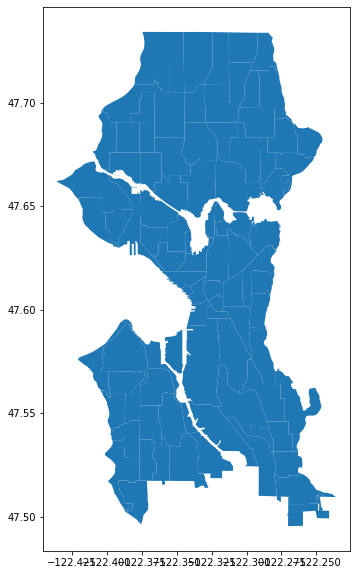

In [ ]:
# using Matplotlib's rcParams features
plt.rcParams['figure.figsize'] = [10, 10] #height, width
street_map.plot()

## Which area is expensive ?

**Create another Dataframe with Average Price by Neighbourhood**

In [ ]:
neighbourhoods_price = listings.groupby(['neighbourhood_cleansed'])['price'].mean().to_frame(name = 'mean_price').reset_index()
neighbourhoods_price

,neighbourhood_cleansed,mean_price
0,Adams,177.29
1,Alki,190.34
2,Arbor Heights,144.00
3,Atlantic,154.98
4,Belltown,166.12
5,Bitter Lake,102.73
6,Briarcliff,218.25
7,Brighton,139.57
8,Broadview,245.89
9,Broadway,151.21


**Merge the dataframe with shape file**

In [ ]:
merged = street_map.merge(neighbourhoods_price, how='left', left_on="neighbourhood", right_on="neighbourhood_cleansed")
merged = merged[['neighbourhood', 'geometry', 'mean_price', 'neighbourhood_group']]
merged.head()

,neighbourhood,geometry,mean_price,neighbourhood_group
0,Wallingford,"MULTIPOLYGON (((-122.34731 47.66501, -122.3464...",143.11,Other neighborhoods
1,West Queen Anne,"MULTIPOLYGON (((-122.35692 47.63959, -122.3569...",230.44,Queen Anne
2,Adams,"MULTIPOLYGON (((-122.37634 47.67592, -122.3762...",177.29,Ballard
3,West Woodland,"MULTIPOLYGON (((-122.37634 47.67592, -122.3760...",147.86,Ballard
4,East Queen Anne,"MULTIPOLYGON (((-122.35692 47.63959, -122.3569...",178.31,Queen Anne


**PLot the Map**

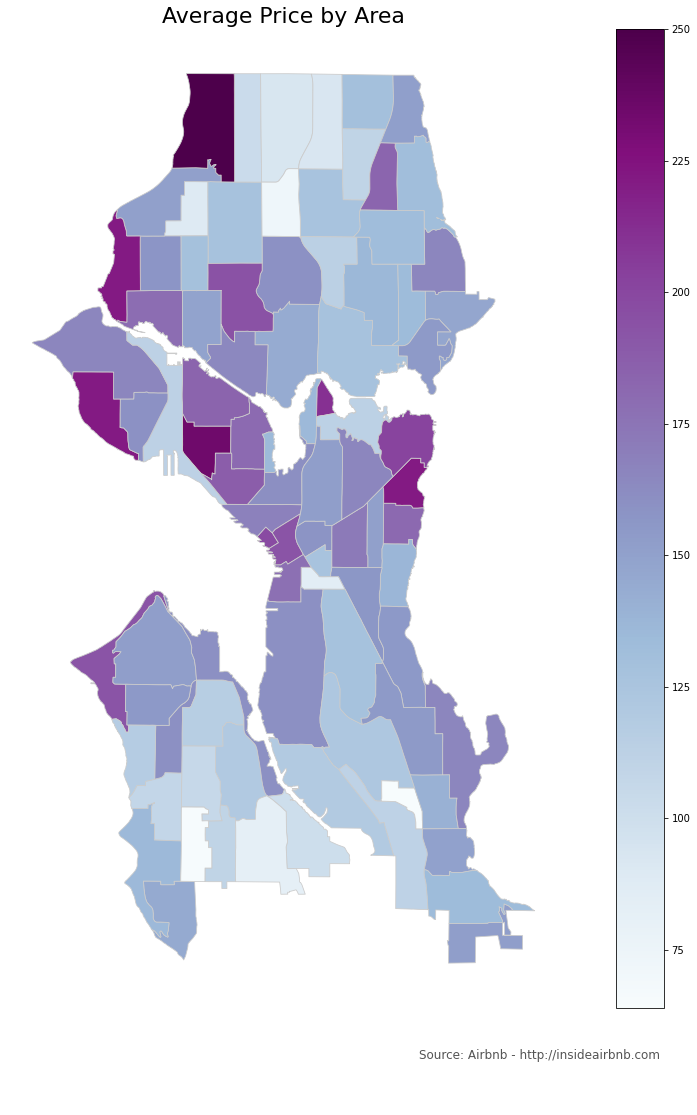

In [ ]:
# set the value column that will be visualised
variable = 'mean_price'

# set the range for the choropleth values
vmin, vmax = 64, 250

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 18))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title('Average Price by Area', fontdict={'fontsize': '22', 'fontweight' : '3'})
ax.annotate('Source: Airbnb - http://insideairbnb.com', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it

# add the colorbar to the figure
fig.colorbar(sm)

# create map
merged.plot(column=variable, cmap='BuPu', linewidth=0.8, ax=ax, edgecolor='0.8')

plt.savefig('Average_Area_By_Price.png', bbox_inches='tight')

# Add Labels
#merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
#merged['coords'] = [coords[0] for coords in merged['coords']]
#for idx, row in merged.iterrows():
#    plt.annotate(s=row['neighbourhood'], xy=row['coords'],horizontalalignment='center')

**Top 5 Expensive Areas :**
* Broadview
* Queen Anne
* Sunset Hill
* Briarcliff
* Denny Blake

**Note: These expensive Seattle neighborhoods are purely based on prices of the listing on Airbnb. However, some of the names in the list are actual rich neighborhood of Seattle.** 
Source: https://www.seattlemet.com/home-and-real-estate/the-most-expensive-neighborhoods-in-seattle-real-estate

## Which Area is the Best?

**Create another Dataframe with Average Ratings by Neighbourhood**

In [ ]:
neighbourhoods_ratings = listings.groupby(['neighbourhood_cleansed'])['review_scores_location'].mean().to_frame(name = 'mean_ratings').reset_index()
neighbourhoods_ratings

,neighbourhood_cleansed,mean_ratings
0,Adams,4.91
1,Alki,4.94
2,Arbor Heights,4.79
3,Atlantic,4.75
4,Belltown,4.91
5,Bitter Lake,4.72
6,Briarcliff,4.95
7,Brighton,4.65
8,Broadview,4.84
9,Broadway,4.89


**Merge the dataframe with shape file**

In [ ]:
merged_ratings = street_map.merge(neighbourhoods_ratings, how='left', left_on="neighbourhood", right_on="neighbourhood_cleansed")
merged_ratings = merged_ratings[['neighbourhood', 'geometry', 'mean_ratings', 'neighbourhood_group']]
merged_ratings.head()

,neighbourhood,geometry,mean_ratings,neighbourhood_group
0,Wallingford,"MULTIPOLYGON (((-122.34731 47.66501, -122.3464...",4.88,Other neighborhoods
1,West Queen Anne,"MULTIPOLYGON (((-122.35692 47.63959, -122.3569...",4.94,Queen Anne
2,Adams,"MULTIPOLYGON (((-122.37634 47.67592, -122.3762...",4.91,Ballard
3,West Woodland,"MULTIPOLYGON (((-122.37634 47.67592, -122.3760...",4.89,Ballard
4,East Queen Anne,"MULTIPOLYGON (((-122.35692 47.63959, -122.3569...",4.94,Queen Anne


**Plot the Map**

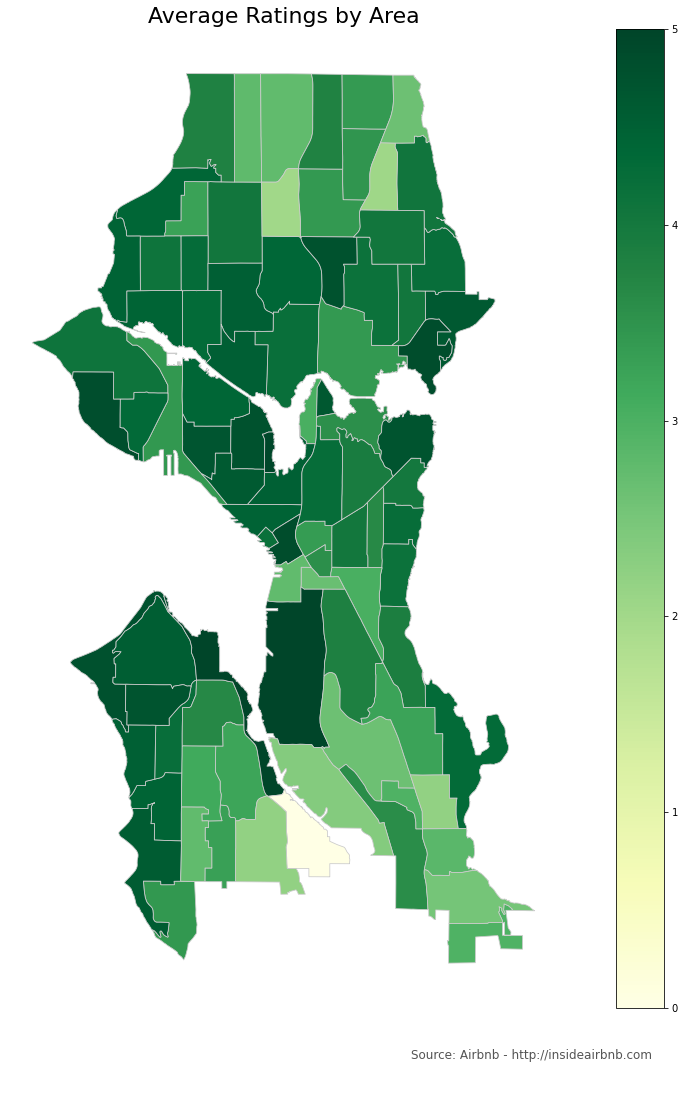

In [ ]:
# set the value column that will be visualised
variable = 'mean_ratings'

# set the range for the choropleth values
vmin, vmax = 0, 5

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 18))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title('Average Ratings by Area', fontdict={'fontsize': '22', 'fontweight' : '3'})
ax.annotate('Source: Airbnb - http://insideairbnb.com', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it

# add the colorbar to the figure
fig.colorbar(sm)

# create map
merged_ratings.plot(column=variable, cmap='YlGn', linewidth=0.8, ax=ax, edgecolor='0.8')

plt.savefig('Average_Ratings_By_Area.png', bbox_inches='tight')

# Add Labels
#merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
#merged['coords'] = [coords[0] for coords in merged['coords']]
#for idx, row in merged.iterrows():
#    plt.annotate(s=row['neighbourhood'], xy=row['coords'],horizontalalignment='center')

**Briarcliff wins the spot with highest ratings and also highest price.**

**Top Rated Areas** :
* Industrial District
* Westlake
* Laurelhurst
* Central Business District
* Briarcliff

# Which type of Properties are listed in Seattle?

**Create a dataframe for the type of properties**

In [ ]:
property_type_counts = listings.groupby(['property_type'])['property_type'].count().to_frame(name = 'counts').reset_index()
property_type_counts
#property_type_counts.sort_values(by=['counts'])

,property_type,counts
0,Boat,3
1,Camper/RV,2
2,Casa particular,2
3,Entire bungalow,25
4,Entire cabin,4
5,Entire condominium (condo),412
6,Entire cottage,39
7,Entire guest suite,543
8,Entire guesthouse,187
9,Entire loft,34


**Data cleaning for property types**

In [ ]:
property_type_counts_new = property_type_counts.copy()
property_type_counts_new.set_index('property_type')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*townhouse.*$)', 'Townhouse')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*condo.*$)', 'Condominium')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*oat.*$)', 'Boathouse')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*loft.*$)', 'Loft')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*hotel.*$)', 'Hotel')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*iny.*$)', 'House')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*RV.*$)', 'Camper/RV/Tent')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*Tent.*$)', 'Camper/RV/Tent')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*Casa.*$)', 'Apartment')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*unit.*$)', 'Apartment')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*apartment.*$)', 'Apartment')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*bed.*$)', 'Apartment')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*bungalow.*$)', 'House')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*villa.*$)', 'House')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*cabin.*$)', 'House')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*Farm.*$)', 'House')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*cottage.*$)', 'House')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*earth.*$)', 'House')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*tree.*$)', 'House')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*suite.*$)', 'House')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*home.*$)', 'House')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*guesthouse.*$)', 'Hotel')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace('Private room', 'House')

property_type_counts_new['property_type'] = property_type_counts_new.property_type.str.replace(r'(^.*Shared.*$)', 'Apartment')


#property_type_counts_new['property_type']


**Group by the new 6 categories for listings**

In [ ]:
property_type_counts_renamed = property_type_counts_new.groupby(['property_type'])['counts'].sum().to_frame(name = 'counts').reset_index()
property_type_counts_renamed = property_type_counts_renamed.drop([1, 2])
property_type_counts_renamed

,property_type,counts
0,Apartment,1301
3,Condominium,427
4,Hotel,245
5,House,2012
6,Loft,38
7,Townhouse,316


**Plot the Graph**

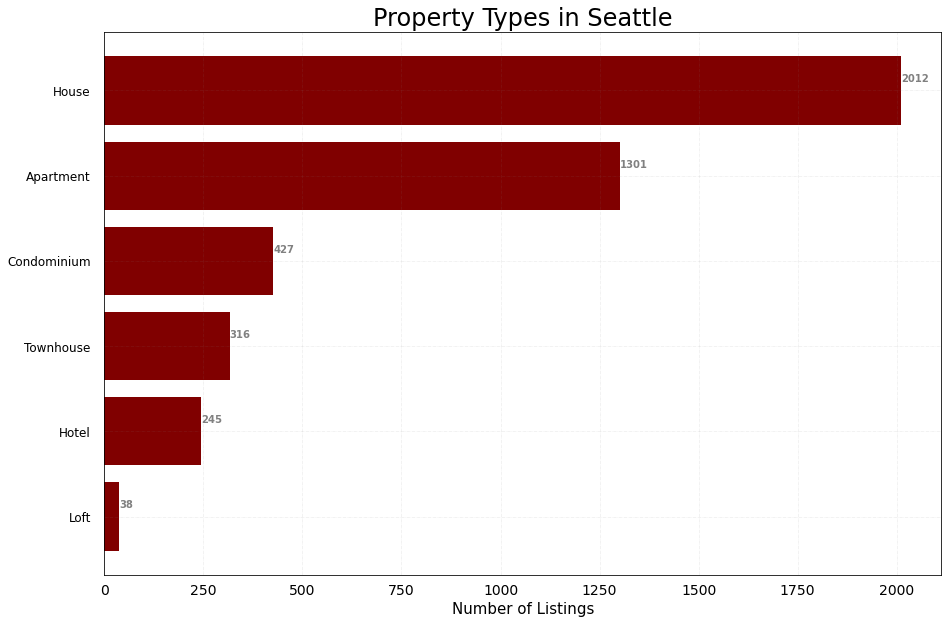

In [ ]:
# sort them in the dataframe to save the effort of sorting them in the graph
property_type_counts_renamed = property_type_counts_renamed.sort_values(by=['counts'])

# figure size
fig, ax = plt.subplots(figsize = (15, 10))

#plot horizonal bargraph
plt.barh(y=property_type_counts_renamed.property_type, width=property_type_counts_renamed.counts, color ='maroon')

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# beautify
plt.xlabel("Number of Listings", fontsize=15)
plt.xticks(fontsize=14)
plt.tick_params(axis='y', labelsize=12)
plt.title("Property Types in Seattle" , fontsize=24)

plt.savefig('Property_Types_In_Seattle.png', bbox_inches='tight')



* **There are more houses listed on Airbnb than apartments and condos together.**
* **Hotels and lofts are fewer in numbers.**

# How popular is Airbnb in Seattle?

**We don't have the booking information in the data. So, I'll be using the reviews as a measure for demand. Why? Because according to the Airbnb 78% of their guests write down the reviews, which is pretty decent number to consider.**

**Create a new dataset for reviews**

In [ ]:
# make a copy of review dataset and add two new columns for year and month
reviews_new = reviews.copy()

reviews_new['year'] = pd.DatetimeIndex(reviews_new['date']).year
reviews_new['month'] = pd.DatetimeIndex(reviews_new['date']).month

reviews_new.head()


,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month
0,2318,146,2008-09-15,2451,Kevin,1000 times better than staying at a hotel.,2008,9
1,2318,126302712,2017-01-10,12332845,Jessica,"Our family (two couples, a two year old and an...",2017,1
2,2318,140977084,2017-04-01,4789466,Ivan,Top of the list locations we have stayed at! T...,2017,4
3,2318,147262504,2017-04-25,55817131,Mike,"SUCH an awesome place. Very clean, quiet and s...",2017,4
4,2318,161806368,2017-06-18,113604590,Pete,We flew quite a distance to be at our only dau...,2017,6


**Type conversion and grouping data**

In [ ]:
# change datatype from object to date
reviews_new['date'] = pd.to_datetime(reviews_new['date'])

# group by date for plotting
reviews_per_date = reviews_new.groupby(['date'])['date'].count().to_frame(name = 'counts').reset_index()
reviews_per_date

,date,counts
0,2008-09-15,1
1,2009-07-17,1
2,2009-11-03,1
3,2009-12-24,1
4,2010-04-23,1
...,...,...
3668,2021-10-19,120
3669,2021-10-20,85
3670,2021-10-21,71
3671,2021-10-22,43


**Plot the graph**

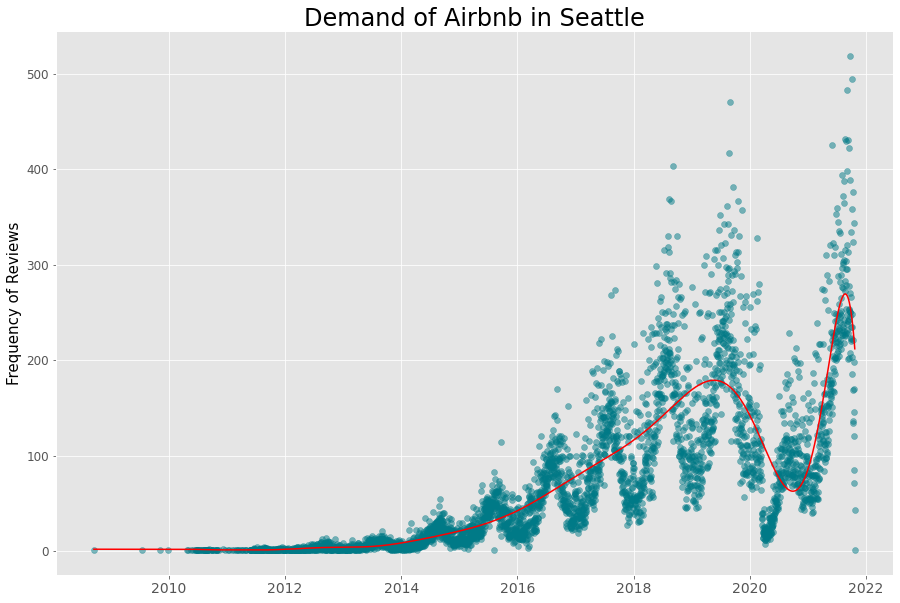

In [ ]:
# figure size
plt.figure(figsize=(15,10))

# ggplot style of plot
plt.style.use('ggplot')

#variable for regression best fit line
x = np.arange(reviews_per_date['date'].size)
fit = np.polyfit(x, reviews_per_date['counts'], deg=12)

#Fit function : y = mx + c [linear regression ]
fit_function = np.poly1d(fit)

# scatter plot
plt.scatter(reviews_per_date['date'], reviews_per_date['counts'], alpha=0.5, color = "#007A87")

#Linear regression plot
plt.plot(reviews_per_date['date'], fit_function(x) , color = 'red')

# beautify
plt.ylabel('Frequency of Reviews', fontsize='15', color = 'black')
plt.xticks(fontsize=14)
plt.tick_params(axis='y', labelsize=12)
plt.title("Demand of Airbnb in Seattle" ,  pad='4.0' , fontsize='24')

plt.savefig('Demand_Of_Airbnb_In_Seattle.png', bbox_inches='tight')


* **The number of listings receiving reviews has increased over the years.**
* **We can see an exponential increase in the number of reviews, which indicates an exponential increase in the demand.**
* **Every year there are peaks and drop in the demand, indicating that certain months are busier compared to the others.**


# Does demand fluctuates according to the seasons of the year?

**Lets study the trend in years when things were normal - 2018, 2019**

**Data preparation**

In [ ]:
# dataframe for 2018 data
reviews_2018 = reviews_new.loc[reviews_new['year'] == 2018 , : ]
reviews_2018.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month
11,2318,236873583,2018-02-20,64024086,John,"Lovely, sunny house. Fully equipped kitchen. ...",2018,2
12,2318,238441861,2018-02-25,1737185,Erica,This house made me want to move to Madrona :)....,2018,2
13,2318,247493599,2018-03-28,22903274,Mark,Casa Madrona was perfect for our family of 5! ...,2018,3
14,2318,250326183,2018-04-04,1800027,Jess,"Megan's house is spacious, attractive, ultra-c...",2018,4
15,2318,256404172,2018-04-22,8924418,Nancy,"While in Seattle for a couple weeks, I rented ...",2018,4


In [ ]:
# dataframe for 2019 data
reviews_2019 = reviews_new.loc[reviews_new['year'] == 2019 , : ]
reviews_2019.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month
21,2318,418653069,2019-03-02,3074799,Nanako,Megan’s home is very spacious and had everythi...,2019,3
22,2318,428702021,2019-03-25,8924418,Nancy,We enjoyed our 3rd stay here as a family with ...,2019,3
23,2318,430447361,2019-03-30,50257562,David,Megan is an amazing host! Her house couldn’t ...,2019,3
24,2318,439797800,2019-04-19,103026448,Diana,an excelent option to stay at! =),2019,4
25,2318,461548229,2019-05-31,219509442,Ann,Great host. Very clean. Really good location.,2019,5


In [ ]:
# group by date for plotting
reviews_2018_counts = reviews_2018.groupby(['date'])['date'].count().to_frame(name = 'counts').reset_index()
reviews_2018_counts.head()

,date,counts
0,2018-01-01,217
1,2018-01-02,126
2,2018-01-03,87
3,2018-01-04,39
4,2018-01-05,57


In [ ]:
# group by date for plotting
reviews_2019_counts = reviews_2019.groupby(['date'])['date'].count().to_frame(name = 'counts').reset_index()
reviews_2019_counts.head()

,date,counts
0,2019-01-01,277
1,2019-01-02,155
2,2019-01-03,98
3,2019-01-04,100
4,2019-01-05,88


**Plot the graph**

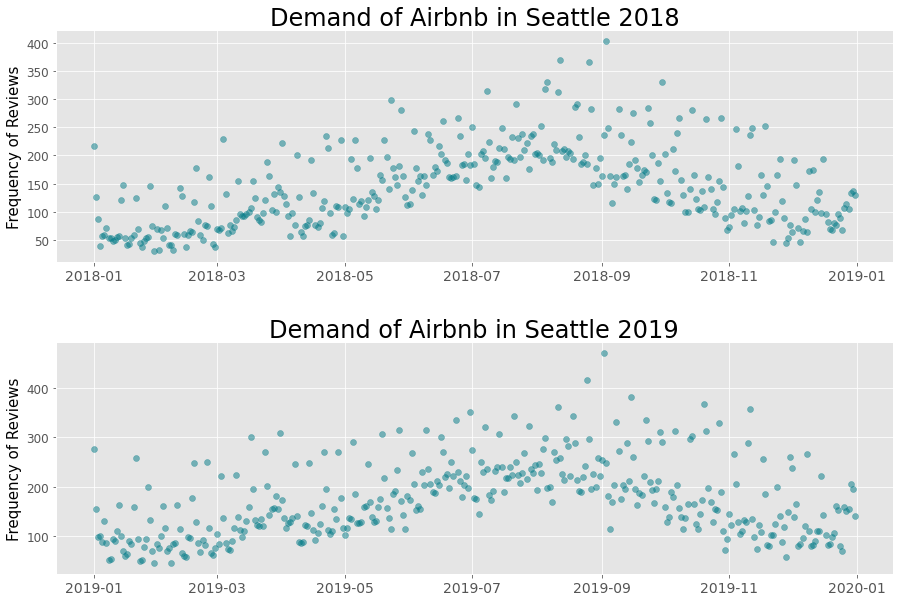

In [ ]:
# figure size
plt.figure(figsize=(15,10))

# ggplot style of plot
plt.style.use('ggplot')

# Plot 1st graph
plt.subplot(2, 1, 1)

# scatter plot
plt.scatter(reviews_2018_counts['date'], reviews_2018_counts['counts'], alpha=0.5, color = "#007A87")

# beautify
plt.ylabel('Frequency of Reviews', fontsize='15', color = 'black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.title("Demand of Airbnb in Seattle 2018" ,  pad='4.0' , fontsize='24')

# Plot 2nd graph
plt.subplot(2, 1, 2)

# scatter plot
plt.scatter(reviews_2019_counts['date'], reviews_2019_counts['counts'], alpha=0.5, color = "#007A87")

# beautify
plt.subplots_adjust(hspace=0.35)
plt.ylabel('Frequency of Reviews', fontsize='15', color = 'black')
plt.xticks(fontsize=14)
plt.tick_params(axis='y', labelsize=12)
plt.title("Demand of Airbnb in Seattle 2019" ,  pad='4.0' , fontsize='24')

plt.savefig('Demand_Of_Airbnb_In_Seattle_2018_2019.png', bbox_inches='tight')

* **There seems to be a consistent pattern in how demand fluctuates across the year, which is reflected in each of the graphs shown above.** 
* **The demand is lowest in January and increases until October, when it begins to falls until the end of the year.** 
* **We can possibly think that due to the holiday season kicking in, with people celebrating Thanksgiving and Christmas at home with their family, leads to a slump in tourism.**


**Lets study the trend for the year nobody wants to talk about - 2020**

In [ ]:
# dataframe for 2020 data
reviews_2020 = reviews_new.loc[reviews_new['year'] == 2020 , : ]
reviews_2020.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month
31,2318,600453223,2020-02-01,40915623,Dan,Megan and her home were excellent. The house ...,2020,2
386,9531,711504907,2020-11-26,31530452,Melissa,Absolutely wonderful. We’re locals and needed ...,2020,11
443,9534,612567165,2020-02-29,261091464,Cindy,"This place is really cute, unique, close to ev...",2020,2
444,9534,625169154,2020-05-17,170361283,Susan,This was a perfect location and experience! I ...,2020,5
445,9534,633674782,2020-06-30,340986384,La'I,You will not be disappointed! The Tangerine is...,2020,6


In [ ]:
# group by date for plotting
reviews_2020_counts = reviews_2020.groupby(['date'])['date'].count().to_frame(name = 'counts').reset_index()
reviews_2020_counts.head()

,date,counts
0,2020-01-01,256
1,2020-01-02,196
2,2020-01-03,127
3,2020-01-04,156
4,2020-01-05,150


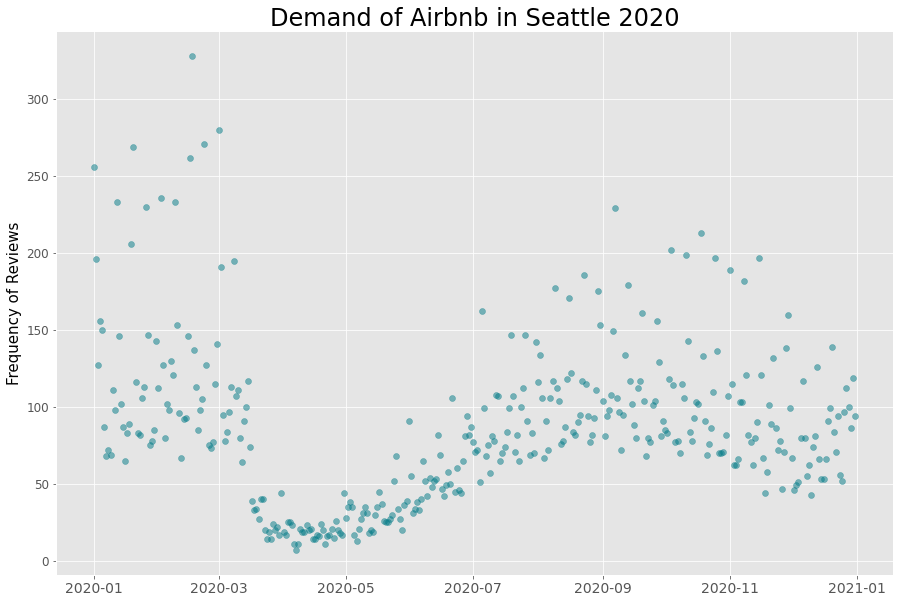

In [ ]:
# figure size
plt.figure(figsize=(15,10))

# ggplot style of plot
plt.style.use('ggplot')

# scatter plot
plt.scatter(reviews_2020_counts['date'], reviews_2020_counts['counts'], alpha=0.5, color = "#007A87")

# beautify
plt.ylabel('Frequency of Reviews', fontsize='15', color = 'black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.title("Demand of Airbnb in Seattle 2020" ,  pad='4.0' , fontsize='24')

plt.savefig('Demand_Of_Airbnb_In_Seattle_2020.png', bbox_inches='tight')


**It confirms how the demand went down during the second wave months and then increased as soon as people started getting over it.**

# How is Airbnb prices across the Year?

In [ ]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587020 entries, 0 to 1587019
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   listing_id      1587020 non-null  int64 
 1   date            1587020 non-null  object
 2   available       1587020 non-null  object
 3   price           1586999 non-null  object
 4   adjusted_price  1586999 non-null  object
 5   minimum_nights  1587020 non-null  int64 
 6   maximum_nights  1587020 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 84.8+ MB


**Calendar has 1587020 listings with their availability and price information. This dataset also has 7 different attributes**

In [ ]:
# make a copy of calendar dataset and add two new columns for year and month
calendar_new = calendar.copy()

# add 2 more columns for year and month
calendar_new['year'] = pd.DatetimeIndex(calendar_new['date']).year
calendar_new['month'] = pd.DatetimeIndex(calendar_new['date']).month
calendar_new['day'] = pd.DatetimeIndex(calendar_new['date']).day_name()

# Removing the $ sign from the price
calendar_new['price'] = calendar_new['price'].replace({'\$':''}, regex = True)

# setting precision to 2
pd.set_option('display.float_format','{:.2f}'.format)

# convert price object to float
calendar_new['price'] = pd.to_numeric(calendar_new['price'],errors = 'coerce')

# Remove listings with price of $0
calendar_new = calendar_new[calendar_new['price'] != 0.00]

# change object to datetime
calendar_new['date'] = pd.to_datetime(calendar_new['date'])

calendar_new.head()


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,day
0,677266,2021-10-23,f,75.00,$75.00,2,180,2021,10,Saturday
1,677266,2021-10-24,t,75.00,$75.00,2,180,2021,10,Sunday
2,677266,2021-10-25,t,75.00,$75.00,2,180,2021,10,Monday
3,677266,2021-10-26,t,75.00,$75.00,2,180,2021,10,Tuesday
4,677266,2021-10-27,t,75.00,$75.00,2,180,2021,10,Wednesday


In [ ]:
calendar_new['date'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                 1587012
unique                    365
top       2022-03-20 00:00:00
freq                     4348
first     2021-10-23 00:00:00
last      2022-10-22 00:00:00
Name: date, dtype: object

In [ ]:
# dataframe for 2021 data
calendar_new_2021 = calendar_new.loc[calendar_new['year'] == 2021 , : ]
calendar_new_2021.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,day
0,677266,2021-10-23,f,75.00,$75.00,2,180,2021,10,Saturday
1,677266,2021-10-24,t,75.00,$75.00,2,180,2021,10,Sunday
2,677266,2021-10-25,t,75.00,$75.00,2,180,2021,10,Monday
3,677266,2021-10-26,t,75.00,$75.00,2,180,2021,10,Tuesday
4,677266,2021-10-27,t,75.00,$75.00,2,180,2021,10,Wednesday


In [ ]:
# group by date for plotting
calendar_new_2021 = calendar_new_2021.groupby(['date'])['price'].mean().to_frame(name = 'price').reset_index()
calendar_new_2021.head()

,date,price
0,2021-10-23,158.50
1,2021-10-24,148.58
2,2021-10-25,146.12
3,2021-10-26,144.86
4,2021-10-27,145.25


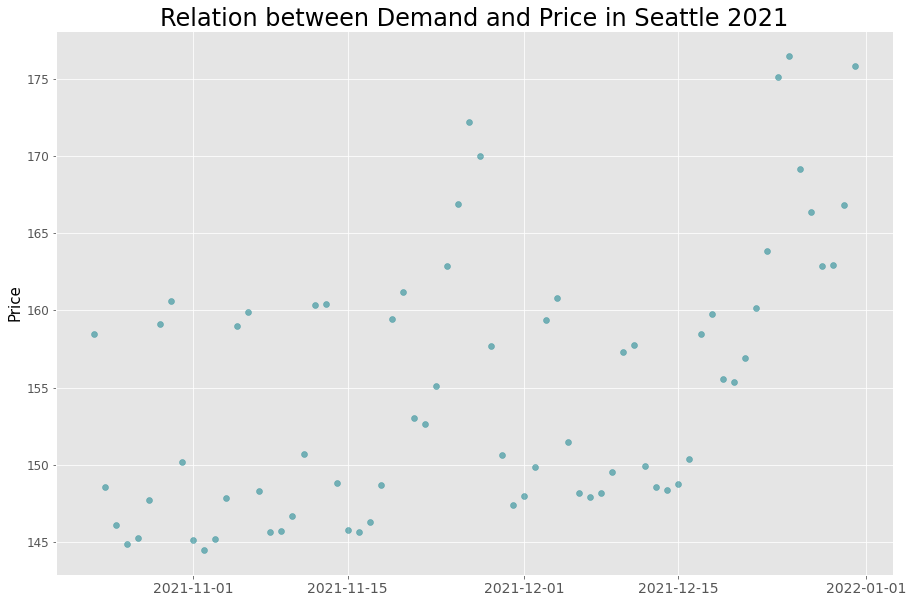

In [ ]:
# figure size
plt.figure(figsize=(15,10))

# ggplot style of plot
plt.style.use('ggplot')

# scatter plot
plt.scatter(calendar_new_2021['date'], calendar_new_2021['price'], alpha=0.5, color = "#007A87")

# beautify
plt.ylabel('Price', fontsize='15', color = 'black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.title("Relation between Demand and Price in Seattle 2021" ,  pad='4.0' , fontsize='24')

plt.savefig('Demand_and_Price_In_Seattle_2021.png', bbox_inches='tight')

* Due to lack of historical data, can't answer this question.
* We only have price of the listings from October 2021 to Oct 2022. Wierd!
* Also, 2021 is not an ideal refrence for any business data.

# Are Weekends epensive to Book?

**Create a dataset to answer this question**

In [ ]:
calendar_new_days = calendar_new.groupby(['date' , 'day'])['price'].mean().to_frame(name = 'price').reset_index()
calendar_new_days.head()

,date,day,price
0,2021-10-23,Saturday,158.50
1,2021-10-24,Sunday,148.58
2,2021-10-25,Monday,146.12
3,2021-10-26,Tuesday,144.86
4,2021-10-27,Wednesday,145.25


**Plot the graph**

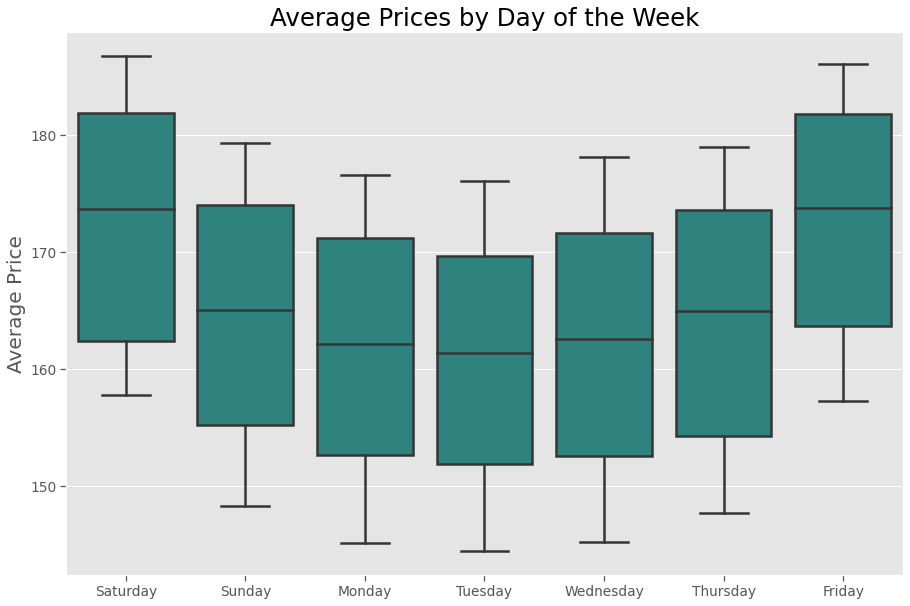

In [ ]:
# Set fihure size
plt.figure(figsize=(15,10))

# Setting seaborn style is a pain, lets do it.
sns.set_context("notebook" , font_scale=1.25, rc={"lines.linewidth":2.5})
custom_palette = sns.color_palette("viridis" , 1)

# Plot the graph
boxplot = sns.boxplot( x=calendar_new_days['day'], y=calendar_new_days['price'],  palette= custom_palette)

# beautify
boxplot.axes.set_title("Average Prices by Day of the Week", fontsize=24.5)
boxplot.set_xlabel("")
boxplot.set_ylabel("Average Price", fontsize=20)

plt.savefig('Price_By_Day_Of_The_Week.png', bbox_inches='tight')

* **As we can see, Fridays through Sundays are more expensive compared to the other days of the weeks, perhaps due to higher demand for lodging.**

# How is the occupancy for next Year (2022)?

**Airbnb doesn't provide us the booking information but what it does provide is the availability information of the listings from Oct'21 to Oct'22. So, I'm going to use the availabitly of the listing as the measure of the occupancy for the upcoming year.**

**Prepare the dataset**

In [ ]:
calendar_new_2022 = calendar_new.loc[calendar_new['year'] == 2022 , : ]
calendar_new_2022.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,day
140,1696194,2022-01-01,t,165.00,$165.00,30,1125,2022,1,Saturday
141,1696194,2022-01-02,t,165.00,$165.00,30,1125,2022,1,Sunday
142,1696194,2022-01-03,t,165.00,$165.00,30,1125,2022,1,Monday
143,1696194,2022-01-04,t,165.00,$165.00,30,1125,2022,1,Tuesday
144,1696194,2022-01-05,t,165.00,$165.00,30,1125,2022,1,Wednesday


**Calculate the occupancy from availability**

In [ ]:
calendar_new_2022['availability'] = np.where(calendar_new_2022['available']== 'f', 1, 0)
calendar_new_2022.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,day,availability
140,1696194,2022-01-01,t,165.00,$165.00,30,1125,2022,1,Saturday,0
141,1696194,2022-01-02,t,165.00,$165.00,30,1125,2022,1,Sunday,0
142,1696194,2022-01-03,t,165.00,$165.00,30,1125,2022,1,Monday,0
143,1696194,2022-01-04,t,165.00,$165.00,30,1125,2022,1,Tuesday,0
144,1696194,2022-01-05,t,165.00,$165.00,30,1125,2022,1,Wednesday,0


**Group the data by month**

In [ ]:
calendar_new_2022_occu = calendar_new_2022.groupby(['month'])['availability'].sum().to_frame(name = 'availability_count').reset_index()
#calendar_new_2022_occu['Percentage'] = 100 * calendar_new_2022_occu['availability_count']  / calendar_new_2022_occu['availability_count'].sum()
#calendar_new_2022_occu['date'] = calendar_new_2022_occu['date'].astype('object')
calendar_new_2022_occu


,month,availability_count
0,1,42283
1,2,41901
2,3,46216
3,4,51479
4,5,69630
5,6,67748
6,7,72236
7,8,75796
8,9,73050
9,10,53173


In [ ]:
# try heat map

# sns.heatmap(calendar_new_2022_occu,  linewidths=.25)

# didn't look good

Prof, I'd need your help to do a heatmap here. Would love to take it after the final submission.

**Plot the Graph**

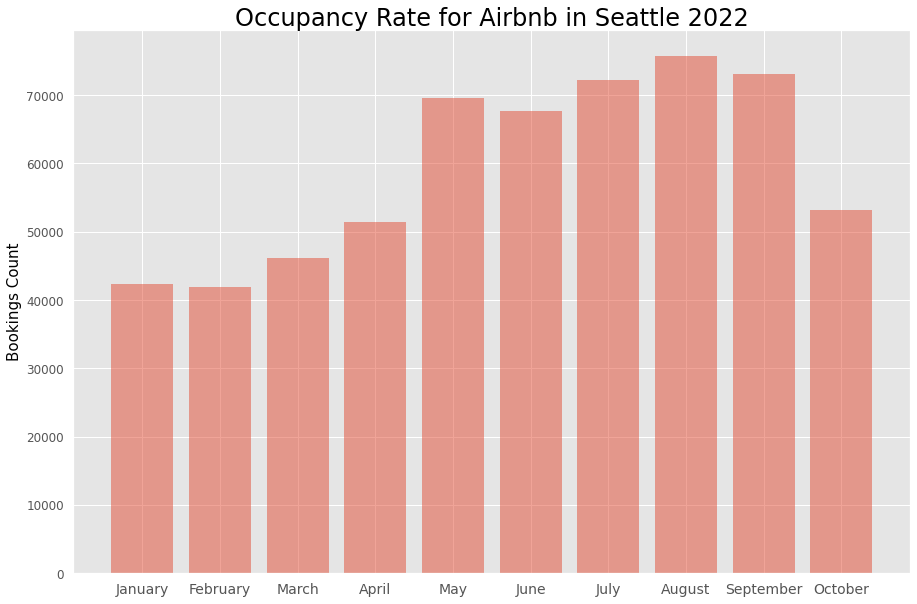

In [ ]:
# set size
plt.figure(figsize=(15,10))

# plot bargraph
plt.bar(calendar_new_2022_occu.month, calendar_new_2022_occu.availability_count ,align='center', alpha=0.5)

# change x ticks lables
my_xticks = ['January','February','March','April', 'May', 'June', 'July', 'August', 'September', 'October']
plt.xticks(calendar_new_2022_occu.month, my_xticks)

# Beautify
plt.ylabel('Bookings Count', fontsize='15', color = 'black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.title("Occupancy Rate for Airbnb in Seattle 2022" ,  pad='4.0' , fontsize='24')
plt.tick_params(bottom = False , left = False)

plt.savefig('Occupancy_Rate_In_Seattle_2022.png', bbox_inches='tight')


* **We can infer that January and February tends to be the quietest in terms of bookings, and the occupancy rate increases as we progress through the year.**
* **This ties up with our results from our analysis of the number of reviews (indicative of the demand) which shows an increasing trend across the year.**

# What does the Review say?

**Want to understand the customer mindset , check their expectations and how well those are met.**

**Plot the word cloud about the most occuring words in reviews by guests**

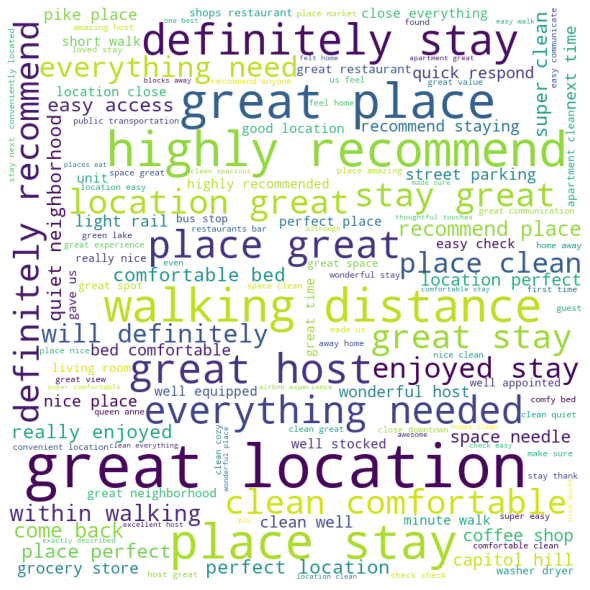

In [ ]:
# satrt with empty variable
comment_words = ''

# use stopwords from the library
stopwords = set(STOPWORDS)
# update your own stop words
stopwords.update(["br", "seattle"])
 
# iterate through the csv file
for val in reviews.comments:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('Reviews_Word_cloud.png', bbox_inches='tight')

* **Words like “comfortable” , "enjoyed" , "recommeneded" in the word cloud let us conclude to a positive experience.**

* **Location and proximity seems to be the key as "location" and “walking” also find frequent mention.**

* **People seem to lay stress on the comfort aspect of their stay as words like "comfortable bed" , "street parking", "quiet neighborhood" are prominent.**

* **Availability of “Restaurants” , "cafes" and "bars" can be a deal breaker too.**

* **Words like “clean”, "well equiped", etc demonstrates the importance of environment, and cleanliness.** 

* **Helpful “host” and “communication” lead to a comfortable stay.**

# What does it take to be a Superhost?

**“Superhost” is an incentive program which is a win-win for the host, Airbnb, and their customers. The superhost gets more bookings, the customer gets best service and Airbnb gets happy customers.**

**Airbnb’s website has a set of requirements that must be fulfilled in order to become one. Maintaining a 4.8 overall rating, a response rate above 90%, etc.**

**Prepare dataset**

In [ ]:
 # create a new dataset
 listings_1 = listings.copy()
 
 # Removing the $ sign from the price
listings_1['host_response_rate'] = listings_1['host_response_rate'].replace({'\%':''}, regex = True)

# not including NA values
listings_1 = listings_1[listings_1['host_response_rate'].notna()]
listings_1 = listings_1[listings_1['review_scores_rating'].notna()]

# change to relevant datatype
listings_1['host_response_rate'] = listings_1['host_response_rate'].astype('int')
listings_1['review_scores_rating'] = listings_1['review_scores_rating'].astype('int')

# Rename t and f to True and False
listings_1['host_is_superhost'] = listings_1.host_is_superhost.str.replace(r'(^.*t.*$)', 'True')
listings_1['host_is_superhost'] = listings_1.host_is_superhost.str.replace(r'(^.*f.*$)', 'False')

**Plot the graph**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


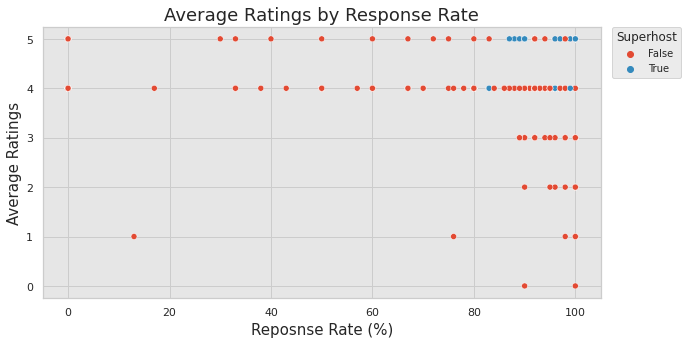

In [ ]:
# Set fihure size
plt.figure(figsize=(10,5))

# Setting seaborn style is a pain, lets do it.
sns.set_style("whitegrid", {"axes.facecolor": "0.9"})
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})

# Plot the graph
scatter = sns.scatterplot('host_response_rate', 'review_scores_rating', data = listings_1, hue='host_is_superhost' , legend = "full")
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0. , title='Superhost' , fontsize='10', title_fontsize='12')


# beautify
scatter.axes.set_title("Average Ratings by Response Rate", fontsize=18)
scatter.set_xlabel("Reposnse Rate (%)", fontsize=15)
scatter.set_ylabel("Average Ratings", fontsize=15)

plt.savefig('Average_Ratings_By_Response_Rate.png', bbox_inches='tight')


* **The scatter plot shows most super-hosts are in the high-rating and high-response-rate region.**

* **We can also see a small fraction of the hosts with response rates less than 90% and average ratings less than 4.8 which violates critera set by Airbnb.** 

* **So clearly, becoming a Superhost takes a lot more than high ratings & response rates.**
